# Инициализация библиотек и необходимых функций

In [311]:
library(repr)
options(repr.plot.width=11, repr.plot.height=7, repr.plot.res = 80, repr.plot.quality = 30)
options(jupyter.plot_mimetypes = 'image/png')

setwd("~/yandexDisk/DIPLOMA/CODE/src")
source("simulations.functions.R", echo=FALSE)
source("../../OWL/O_learning_functions.r", echo=FALSE)
debug.file <- ".various.Rdata/Iter.info"
set.seed(0)

Loading SVMW


In [4]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
number.of.covariates = 30
sample.size <- 200
offsets = seq(0.2, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0,  10,  length=12)

registerDoParallel(cores = 4)
number.of.iters <- 20

offset = 0.1
lambda = 1

# Simulation specifiec functions

In [486]:
ScoreFunction <- function(params) { QFunctionFirstScenario(params, data=test, policy.function=PolicyFunLinearKernel) }

GetScoreForEachParamSet <- function(hyp.grid, opt.fname, opt.fparams, score.func=ScoreFunction) {
    # Replaces necessary params in opt.fparams with row of hyp.grid; 
    # Computes metrics using the score function with two pars: 
    #   opt.result  and  replaced opt.fparams
    # 
    # Args:
    #  score.func - Function to call with result of opt.fname( ) invocation with updated params from hyp.grid.
    #               Should have signature  score.func(opt.result, opt.modified.params)
    opt.results = list()
    stat.list = list()
    for (i in seq_len(NROW(hyp.grid))) {
        opt.modified.params = as.list(modifyList(opt.fparams, hyp.grid[i, , drop=F]))
        param.name = paste(paste(names(hyperparams.grid),  hyp.grid[i, ], sep="="), collapse = ".")
        opt.results[[i]] <- do.call(opt.fname, opt.modified.params)
        stat.list[[i]] <-  score.func(opt.results[[i]])
    } 
    return (unlist(stat.list))
}

In [ ]:
GetDCOwlParam <- function (obs.data, lambda, offset, init.pars){
    coefs <- coef(dc_loop(obs.data$covariates[, -1], obs.data$treatment, obs.data$reward, 
                          offset, lambda, init.pars[-1], init.pars[1]))
    return (coefs)
}

# Сравнение разных ядер

In [651]:
offset.grid <- seq(0.1, 3, length.out = 20)
offset.grid <- lseq(0.1, 35, 20)
# offset.grid <- c(0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1)
lambda.grid <- lambda
hyperparams.grid <- expand.grid(offset=offset.grid ) # , lambda=lambda.grid )

In [628]:
test <- GetSimulationData(test.data.sample.size, number.of.covariates)
train <- GetSimulationData(sample.size, number.of.covariates)

In [ ]:
init.pars = GetInitPars(train, q = 0.6)
opt.params <- list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=init.pars, "approximation.eps"=1e-7)
param.list <- list(obs.data = train, offset = offset, policy.function = PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
mm.scores = GetScoreForEachParamSet(hyperparams.grid, "OptimizeParamsOfPolicyFunction", param.list, ScoreFunction)
# owl scores as quantile regression on upper 1 - q quantile of initial data 
owl.scores = GetScoreForEachParamSet(hyperparams.grid, "GetOwlParams", list(data=train, lambda=lambda, weights = F), ScoreFunction)
owl.scores.weights = GetScoreForEachParamSet(hyperparams.grid, "GetOwlParams", list(data=train, lambda=lambda, weights = T), ScoreFunction)
# cauchy optimization using Newton Raphson algorithm 
opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars,  "func"=CauchyObjFunc.2max, "func.grad"=CauchyObjFunc.grad.2max, "func.hess"=CauchyObjFunc.hess.2max)
param.list <- list(obs.data = train, offset = offset, policy.function = PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
cauchy.scores <- GetScoreForEachParamSet(hyperparams.grid, "OptimizeParamsOfPolicyFunction", param.list, ScoreFunction)
# OWL solution using dc_loop function from kosorok code
dc_loop.param.list <- list(obs.data = train, offset = offset,  lambda=lambda, init.pars=init.pars)
dc_loop.scores <- GetScoreForEachParamSet(hyperparams.grid, "GetDCOwlParam", dc_loop.param.list, ScoreFunction)
# meshalkin loss function scores using Newton Raphson algorithm with precise hessian
opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars,  "func"=MeshalkinObjFunc.2max, "func.grad"=MeshalkinObjFunc.grad.2max, "func.hess"=MeshalkinObjFunc.hess.2max)
param.list <- list(obs.data = train, offset = offset, policy.function = PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
mesh.with.hess.scores <- GetScoreForEachParamSet(hyperparams.grid, "OptimizeParamsOfPolicyFunction", param.list, ScoreFunction)
# meshalkin loss function scores using Newton Raphson algorithm with numeric hessian
opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars,  "func"=MeshalkinObjFunc.2max, "func.grad"=MeshalkinObjFunc.grad.2max)
param.list <- list(obs.data = train, offset = offset, policy.function = PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
mesh.scores <- GetScoreForEachParamSet(hyperparams.grid, "OptimizeParamsOfPolicyFunction", param.list, ScoreFunction) 

MML2PenalizedProperIters Converged after  3  iterations
MML2PenalizedProperIters Converged after  5  iterations
MML2PenalizedProperIters Converged after  5  iterations
MML2PenalizedProperIters Converged after  3  iterations
MML2PenalizedProperIters Converged after  4  iterations
MML2PenalizedProperIters Converged after  8  iterations
MML2PenalizedProperIters Converged after  7  iterations
MML2PenalizedProperIters Converged after  3  iterations
MML2PenalizedProperIters Converged after  4  iterations
MML2PenalizedProperIters Converged after  3  iterations
MML2PenalizedProperIters Converged after  2  iterations
MML2PenalizedProperIters Converged after  2  iterations
MML2PenalizedProperIters Converged after  2  iterations
MML2PenalizedProperIters Converged after  2  iterations
MML2PenalizedProperIters Converged after  2  iterations
MML2PenalizedProperIters Converged after  2  iterations
MML2PenalizedProperIters Converged after  2  iterations
MML2PenalizedProperIters Converged after  2  ite

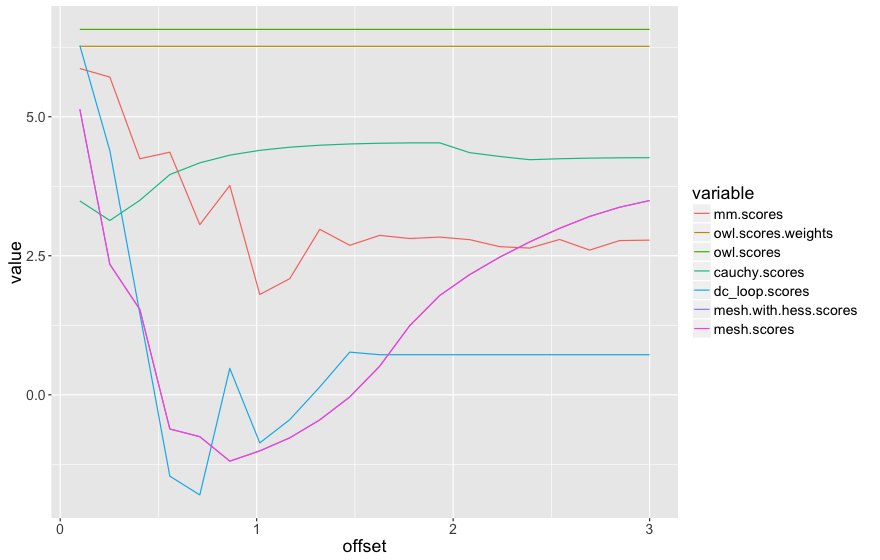

In [631]:
stat.results <- t(rbind(t(hyperparams.grid), mm.scores, owl.scores.weights,  owl.scores, cauchy.scores, 
                        dc_loop.scores, mesh.with.hess.scores, mesh.scores))
ggplot(melt(data.frame(stat.results ), id.vars = "offset"), aes(x=offset, y=value, colour=variable)) + geom_line() + theme(text = element_text(size=16))

# Test if opt function is properly implemented

In [630]:
ScoreFunctionFunctionFunction

function(params) { QFunctionFirstScenario(params, data=test, policy.function=PolicyFunLinearKernel) }

In [617]:
opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars,  "func"=CauchyObjFunc.2max, "func.grad"=CauchyObjFunc.grad.2max, "func.hess"=CauchyObjFunc.hess.2max)
param.list <- list(obs.data = train, offset = offset, policy.function = PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
meshalkin.scores <- GetScoreForEachParamSet(hyperparams.grid, "OptimizeParamsOfPolicyFunction", param.list, ScoreFunction)

Code:  2  Message:  successive function values within tolerance limit 
Code:  1  Message:  gradient close to zero 
Code:  2  Message:  successive function values within tolerance limit 
Code:  1  Message:  gradient close to zero 
Code:  2  Message:  successive function values within tolerance limit 
Code:  2  Message:  successive function values within tolerance limit 
Code:  2  Message:  successive function values within tolerance limit 
Code:  1  Message:  gradient close to zero 
Code:  2  Message:  successive function values within tolerance limit 
Code:  2  Message:  successive function values within tolerance limit 
Code:  1  Message:  gradient close to zero 
Code:  2  Message:  successive function values within tolerance limit 
Code:  1  Message:  gradient close to zero 
Code:  2  Message:  successive function values within tolerance limit 
Code:  2  Message:  successive function values within tolerance limit 
Code:  1  Message:  gradient close to zero 
Code:  1  Message:  gradie

In [649]:
lseq(0.1, 35, 20)

[1]  0.1000000  0.1361126  0.1852664  0.2521709  0.3432363  0.4671879
 [7]  0.6359016  0.8655422  1.1781119  1.6035587  2.1826454  2.9708553
[13]  4.0437083  5.5039963  7.4916323 10.1970552 13.8794766 18.8917160
[19] 25.7140051 35.0000000

In [ ]:
neg_lossf <- function(u) {- CauchyLoss(u, c)} 
neg_lossf_diff <- function(u) {- CauchyLoss.grad(u, c)} 
neg_lossf_hess <- function(u) {- CauchyLoss.hess(u, c)} 

start.points <- seq(-1, 1, 0.01)
for (p in start.points) {
    opt.params = list("opt.func"=NROptimize, "init.pars"=p,  "func"=neg_lossf, "func.grad"=neg_lossf_diff, "func.hess"=neg_lossf_hess)
    param.list <- list(obs.data = train, offset = offset, policy.function = PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
     <- GetScoreForEachParamSet(hyperparams.grid, "OptimizeParamsOfPolicyFunction", param.list, ScoreFunction)
}


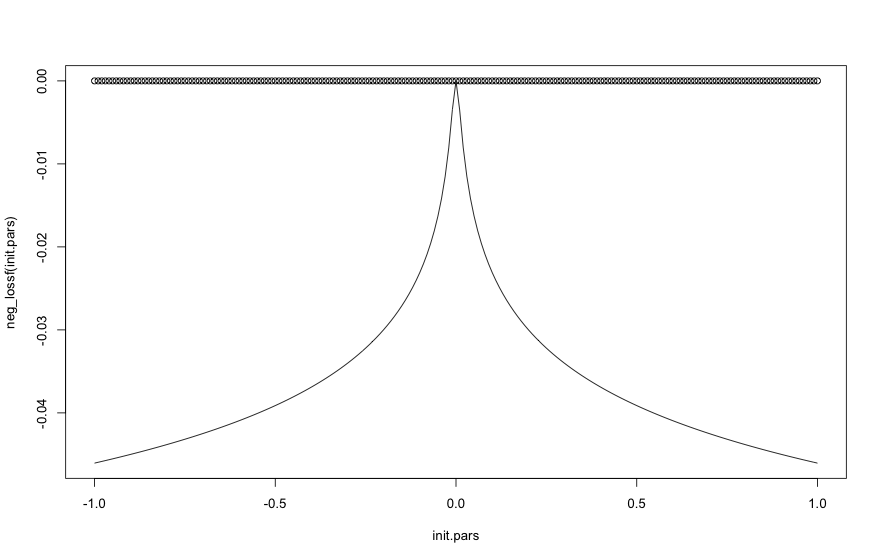

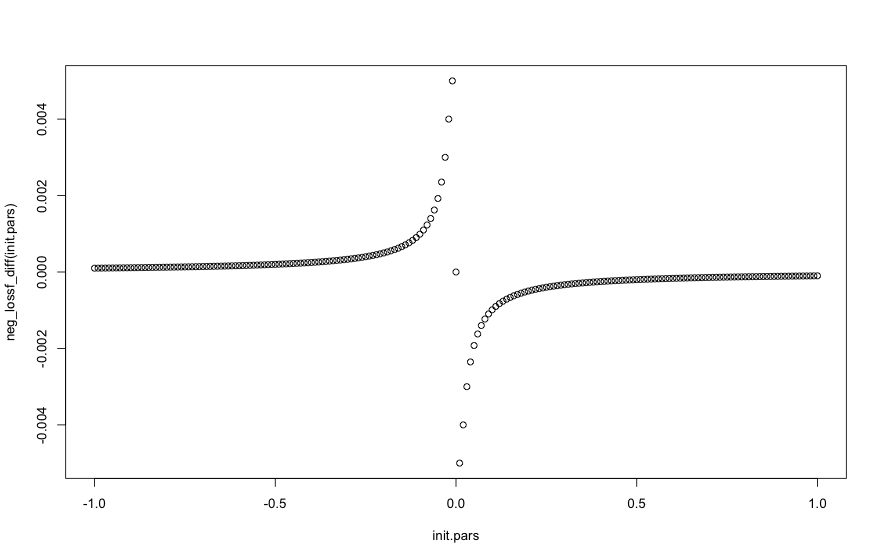

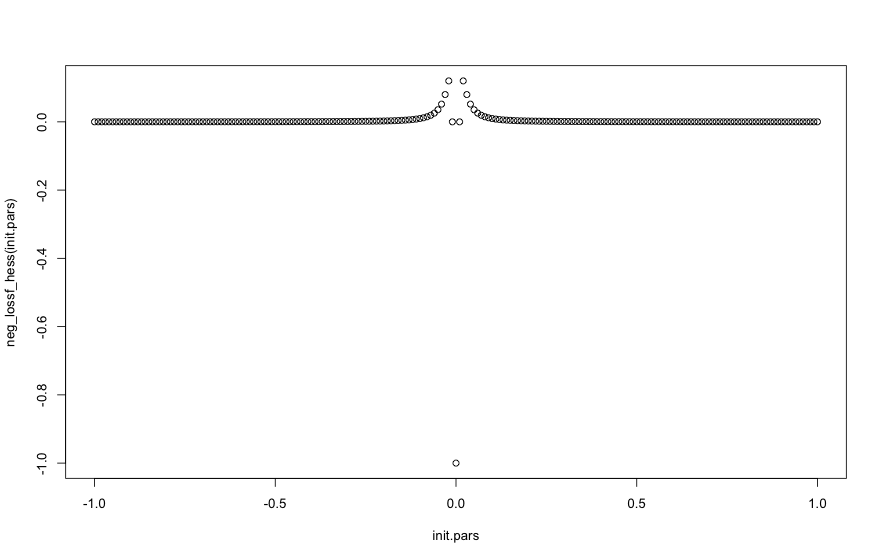

In [619]:
c = 0.01
neg_lossf <- function(u) {- CauchyLoss(u, c)} 
neg_lossf_diff <- function(u) {- CauchyLoss.grad(u, c)} 
neg_lossf_hess <- function(u) {- CauchyLoss.hess(u, c)} 

init.pars <- seq(-1, 1, 0.01)
max_vals <- sapply(init.pars, function(p) (maxNR(neg_lossf, grad=neg_lossf_diff, 
                                                 hess=NULL,  
                                                 start=p)$maximum))
plot(init.pars, neg_lossf(init.pars), type="l")
points(init.pars, max_vals)
plot(init.pars, neg_lossf_diff(init.pars))
plot(init.pars, neg_lossf_hess(init.pars))

# Comparison of different methods params
### ( with regard to different train data and fixed )

In [16]:
global.stat <- list()

test <- GetSimulationData(test.data.sample.size, number.of.covariates)
for (i in seq(1,number.of.iters)) {
    train <- GetSimulationData(sample.size, number.of.covariates)
    # rq median model on upper 40% of the best rewards
    init.pars = GetInitPars(train, q = 0.6)
    # handmade approximate MM algorithm
    opt.params <- list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=init.pars, "approximation.eps"=1e-7)
    pars.dca.MM <- OptimizeParamsOfPolicyFunction(obs.data = train, offset = offset, policy.function = PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
    
    pars.owl <- GetOwlParams(train, lambda, weights = F)
    pars.owl.weights <- GetOwlParams(train, lambda, weights = T)
    pars.owl.dc_loop <- coef(dc_loop(train$covariates[, -1], train$treatment, train$reward, offset, 
                                     lambda, init.pars[-1], init.pars[1]))
    
#     opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars, "use.hessian"=TRUE)
#     pars.nr <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
#     opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars, "use.hessian"=FALSE)
#     pars.nr.without.hess <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)

    opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars,  "func"=CauchyObjFunc.2max, "func.grad"=CauchyObjFunc.grad.2max, "func.hess"=CauchyObjFunc.hess.2max)
    pars.cauchy <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)

    opt.decision <- c(1, 0.5, 0.5 , rep(0, length(pars.owl ) - 3))
    data.list <- list("train"=train, "test"=test)
    params.list  <- list("Init.pars"=pars.owl,
                         "MM.approx"=pars.dca.MM, 
                         "OWL.dc_loop"=pars.owl.dc_loop,
#                          "NR" =  pars.nr,
#                          "NR.without.hess" = pars.nr.without.hess, 
                         "Ideal"=opt.decision,
                         "OWL"=pars.owl, 
                         "Cauchy"=pars.cauchy, 
                         "OWL.weights"=pars.owl.weights
                        ) 
    iter.stat <- GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
    global.stat  <- rbind(global.stat, iter.stat)
}

MML2PenalizedProperIters Converged after  3  iterations
Code:  3  Message:  Last step could not find a value above the current.
Boundary of parameter space?  
Consider switching to a more robust optimisation method temporarily. 
MML2PenalizedProperIters Converged after  3  iterations
Code:  3  Message:  Last step could not find a value above the current.
Boundary of parameter space?  
Consider switching to a more robust optimisation method temporarily. 
MML2PenalizedProperIters Converged after  3  iterations
Code:  3  Message:  Last step could not find a value above the current.
Boundary of parameter space?  
Consider switching to a more robust optimisation method temporarily. 
MML2PenalizedProperIters Converged after  7  iterations
Code:  3  Message:  Last step could not find a value above the current.
Boundary of parameter space?  
Consider switching to a more robust optimisation method temporarily. 
MML2PenalizedProperIters Converged after  5  iterations
Code:  3  Message:  Last ste

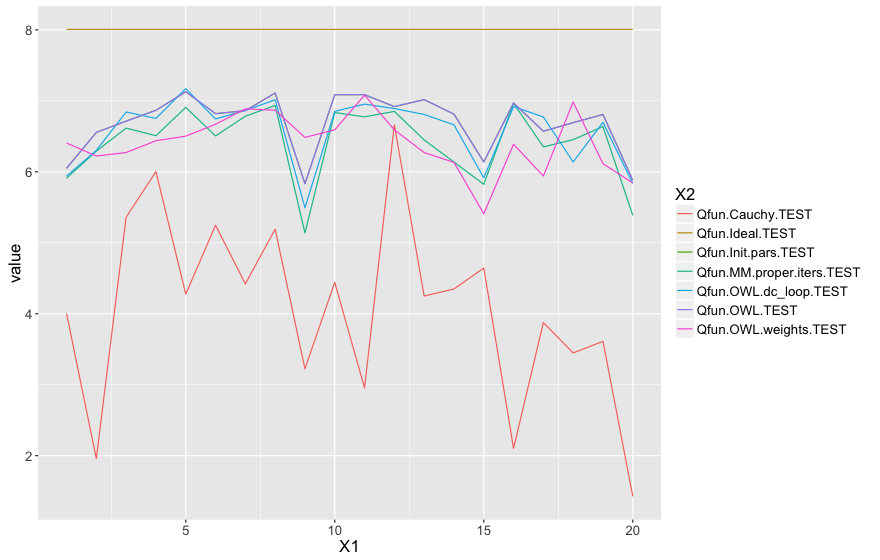

In [17]:
melt = reshape::melt
gl.stat.df <- apply(global.stat, 2, unlist)
vf.train <- melt(gl.stat.df[, grep("VF.*TRAIN", colnames(gl.stat.df))])
vf.test <- melt(gl.stat.df[, grep("VF.*TEST", colnames(gl.stat.df))])
obj.train <- melt(gl.stat.df[, grep("OBJ.*TRAIN", colnames(gl.stat.df))])
obj.test <- melt(gl.stat.df[, grep("OBJ.*TEST", colnames(gl.stat.df))])
q.train <- melt(gl.stat.df[, grep("Q.*TRAIN", colnames(gl.stat.df))])
q.test <- melt(gl.stat.df[, grep("Q.*TEST", colnames(gl.stat.df))])

# ggplot(q.train , aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(vf.train, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
ggplot(q.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(vf.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(obj.train, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(obj.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
ggplot(q.test, aes(X1, value))  + geom_boxplot(aes(colour = X2)) + theme(text = element_text(size=15))

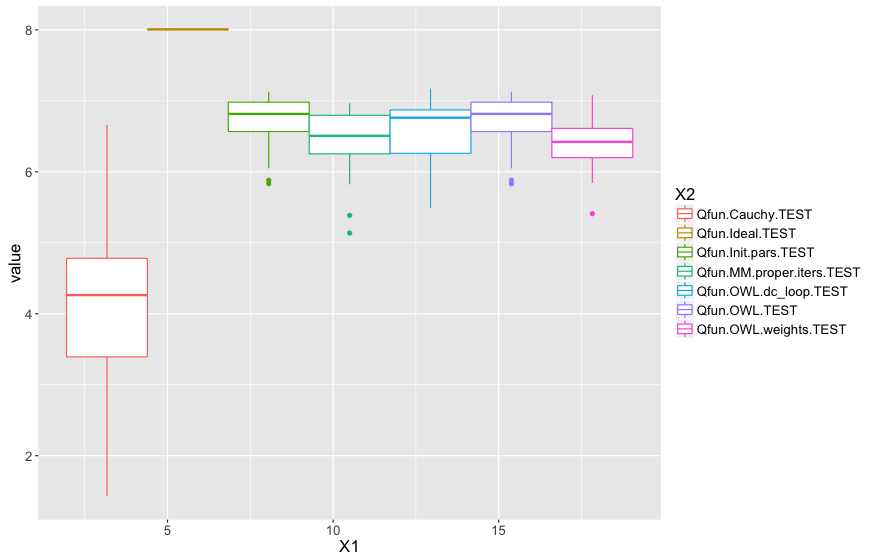

In [18]:
ggplot(q.test, aes(X1, value))  + geom_boxplot(aes(colour = X2)) + theme(text = element_text(size=15))

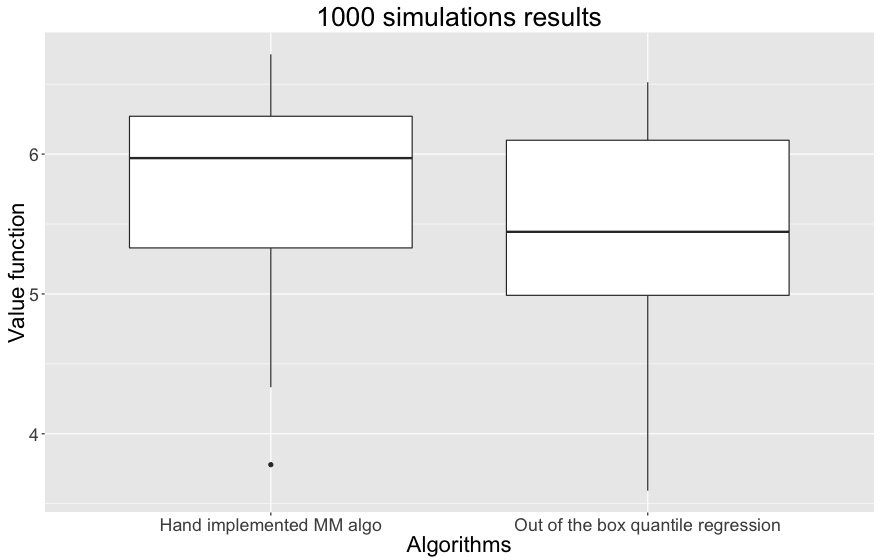

In [44]:
# pdf("~/yandexDisk/DIPLOMA/REPORTS/Presentations/imgs/MMvsRQ.pdf", width = 8, height=6 )
data.to.plot <-  q.test[q.test$X2 %in% c("Qfun.MM.proper.iters.TEST", "Qfun.OWL.dc_loop.TEST"), ]
ggplot(data.to.plot , aes(factor(data.to.plot$X2, labels = c("Hand implemented MM algo", 
                                                             "Out of the box quantile regression")), y=value  )) +  
    geom_boxplot() +  
    theme(text = element_text(size=20)) + 
    xlab("Algorithms") +
    ylab("Value function") +
    ggtitle("1000 simulations results")
# dev.off()